# 3-and-out rates

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import requests

import team_colors
from adjustText import adjust_text

# Seaborn style settings
sns.set(style="whitegrid", 
        palette="pastel", 
        font='IBM Plex Mono', 
        font_scale = 1.1,
        rc= {'grid.color': '.95', 
             'xtick.color': 'dimgray', 
             'ytick.color': 'dimgray',
             'axes.labelcolor': '.3',
            })

In [24]:
import matplotlib.font_manager as font_manager 

font_manager._rebuild()

In [3]:
# In case matplotlib misinterprets the font weights
# This fix doesn't always work, though, try restarting the kernel in that case.

from fontTools.ttLib import TTFont, TTCollection
from matplotlib.font_manager import fontManager
from pathlib import Path

for font in fontManager.ttflist:
    path = Path(font.fname)
    
    if (path.suffix == '.ttc'):
        font_collection = TTCollection(path).fonts
    else:
        font_collection = [TTFont(path)]
    
    for font_obj in font_collection:
        try:
            font.weight = font_obj['OS/2'].usWeightClass
        except:
            pass

fontManager._findfont_cached.cache_clear()

## Data

In [25]:
df = pd.read_csv("../data/nflscrapR/reg_pbp_2019.csv", low_memory=False)

#df = pd.concat(map(pd.read_csv, glob.glob('../data/*.csv')))

In [26]:
#Adding week data to main dataframe

year = 2019

try:
    response_reg = requests.get('http://www.nfl.com/feeds-rs/schedules/{}.json'.format(year)).json()
except requests.exceptions.RequestException as e:
    print(e)

schedules = pd.DataFrame.from_dict(response_reg['gameSchedules'])
schedules = schedules.loc[schedules['seasonType'] == 'REG', ['gameId', 'week']]

schedules = schedules.rename(columns={'gameId' : 'game_id'})

df = df.merge(schedules, how='left', on=['game_id'])

In [27]:
df.head()

,Unnamed: 0,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,week
0,1,35,2019090500,CHI,GB,GB,away,CHI,CHI,35.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
1,2,50,2019090500,CHI,GB,GB,away,CHI,GB,75.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
2,3,71,2019090500,CHI,GB,GB,away,CHI,GB,75.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
3,4,95,2019090500,CHI,GB,GB,away,CHI,GB,75.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
4,5,125,2019090500,CHI,GB,GB,away,CHI,GB,85.0,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1


In [28]:
df['converted'] = (df['yards_gained'] >= df['ydstogo']) & (df['yards_gained'] > 0) & (np.isnan(df['down']) == False)
df['victory_formation'] = (df['qb_kneel'] == 1) & (df['quarter_end'].shift(-1) == 1)
df['drive_id'] = df['game_id'].map(str) + '-' +  df['drive'].map(str)

In [29]:
# Determining the drive team. First team to play on the drive id.
# Extract drive_ids and their minimum play number, then join back in the team into the main dataframe?

drive_teams = df.sort_values(['game_id', 'play_id'], ascending=True).groupby('drive_id')['posteam'].first().reset_index()
drive_teams = drive_teams.rename(columns={"posteam": "drive_team"})
df = pd.merge(df, drive_teams, how='left')

In [30]:
df['scoring_drive'] = (df['drive_team'] == df['posteam']) & (df['sp'] == 1)
df['fg_attempt'] = (df['play_type'] == 'field_goal') & (df['sp'] == 0)

In [31]:
drives = df.groupby(['game_id', 'drive_team', 'drive_id', 'defteam'])['converted', 'victory_formation', 'scoring_drive', 'fg_attempt'].max().reset_index()
drives['three_and_out'] = (
    (drives['converted'] == False) & 
    (drives['victory_formation'] == False) & 
    (drives['scoring_drive'] == False) &
    (drives['fg_attempt'] == False)
)

In [32]:
x = drives.groupby('drive_team')['three_and_out'].mean().reset_index().sort_values('three_and_out', ascending=True)
y = drives.groupby('defteam')['three_and_out'].mean().reset_index().sort_values('three_and_out', ascending=True).rename(columns={"three_and_out": "three_and_out_allowed",
                                                                                                                                'defteam': 'drive_team'})

data = x.merge(y, how='left', on='drive_team')
data

,drive_team,three_and_out,three_and_out_allowed
0,HOU,0.135135,0.226667
1,DAL,0.178082,0.270270
2,SF,0.185714,0.455882
3,KC,0.186667,0.256410
4,BAL,0.213333,0.164384
5,DET,0.216216,0.295775
6,CAR,0.230769,0.303797
7,LAC,0.231884,0.211268
8,NO,0.233766,0.320513
9,OAK,0.250000,0.209677


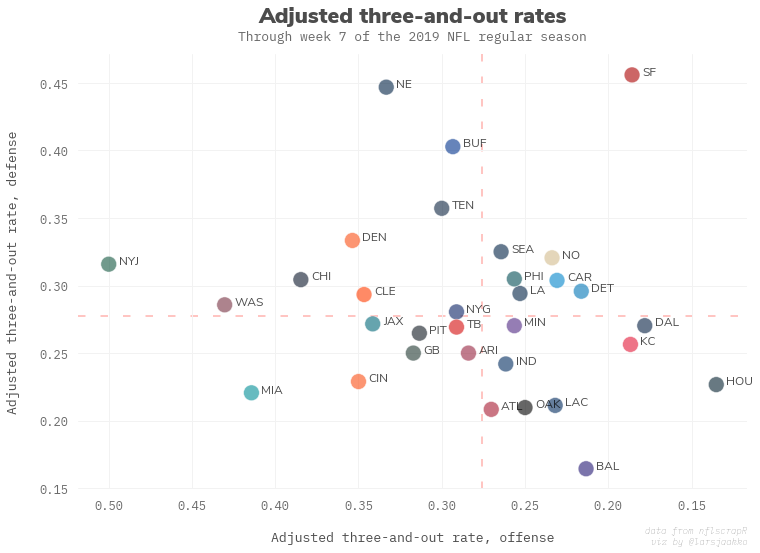

In [38]:
f, ax = plt.subplots(figsize=(12, 8))

week = np.max(df['week'])

# Plotting all other teams and adding names

plt.axhline(np.median(data['three_and_out']), linestyle=(0, (5, 10)), color='r', alpha=0.8, lw=1.5, zorder=-1)
plt.axvline(np.median(data['three_and_out_allowed']), linestyle=(0, (5, 10)), color='r', alpha=0.8, lw=1.5, zorder=-1)

ax.invert_xaxis()

ax = sns.scatterplot(x='three_and_out', 
                     y='three_and_out_allowed',
                     hue='drive_team', 
                     palette=team_colors.get_colors(),
                     data=data,
                     legend=False,
                     alpha=0.6,
                     s=250
                    )

ax.set_title('Adjusted three-and-out rates\n',
              fontfamily='Nunito Sans',
              fontsize=22, 
              weight=900, 
              ha='center', 
              va='bottom', 
              color='black',
              alpha=0.7,
             )

ax.text(x=0.5, 
        y=1.025, 
        s='Through week {} of the 2019 NFL regular season'.format(week), 
        fontsize=13,
        weight=400,
        style='normal',
        color='dimgray', 
        ha='center', 
        va='bottom', 
        transform=ax.transAxes)

ax.text(x=1, 
            y=-0.13, 
            s='data from nflscrapR\nviz by @larsjaakko', 
            fontsize=9,
            weight=400,
            style='italic',
            color='dimgray', 
            ha='right', 
            va='bottom', 
            transform=ax.transAxes)
        
texts = [plt.text(data['three_and_out'][line] - 0.006, data['three_and_out_allowed'][line], data['drive_team'][line], horizontalalignment='left', fontfamily='Nunito Sans', size=12, color='black', alpha=0.7, weight=400) for line in range(0,data.shape[0])]

ax.set_ylabel('Adjusted three-and-out rate, defense\n')
ax.set_xlabel('\nAdjusted three-and-out rate, offense')



#texts.append(plt.text(data[data['posteam'] == 'SF']['return_yards'].values[0], data[data['posteam'] == 'SF']['epa'].values[0], data[data['posteam'] == 'SF']['posteam'].values[0], horizontalalignment='left', size=20, color='black', weight='semibold'))
#adjust_text(texts, force_points=(0.5, 1.5), force_text=(0.5, 1.5))

#plt.xlim(reversed(plt.xlim()))    

sns.despine(
    left=True, 
    right=True, 
    top=True, 
    bottom=True
)
plt.savefig('output/three-and-out/' + 'adjusted_three_and_out_wk{}_{}.png'.format(week, year), format='png', dpi=300, bbox_inches='tight')